In [ ]:
#@title Librerias
!pip install -q torch torchvision timm einops ptflops scikit-image opencv-python pillow tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
import timm
import cv2
from PIL import Image
from tqdm import tqdm
import io
import os
from google.colab import drive, files
# from google.colab.patches import cv2_imshow
from skimage.metrics import peak_signal_noise_ratio as psnr_loss, structural_similarity as ssim_loss, mean_squared_error as mse_loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.4 MB/s eta 0:00:00


In [ ]:
#@title Drive
drive.mount('/content/drive')

input_dir = '/content/drive/MyDrive/UIS/Handson/Uformer_folder/blurry_images'
gt_dir = '/content/drive/MyDrive/UIS/Handson/Uformer_folder/gt_images'
weights_path = '/content/drive/MyDrive/UIS/Handson/Uformer_folder/Uformer_B.pth'
output_dir = '/content/drive/MyDrive/UIS/Handson/Uformer_folder/resultados_uformer'
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Repositorio
!git clone https://github.com/ZhendongWang6/Uformer.git
%cd Uformer

Cloning into 'Uformer'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 137 (delta 57), reused 45 (delta 45), pack-reused 64 (from 2)
Receiving objects: 100% (137/137), 2.15 MiB | 11.56 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/Uformer


In [ ]:
#@title Aplicar blur

try:
  uploaded = files.upload()

  if len(uploaded) > 1:
    raise Exception("Por favor, sube solo un archivo a la vez.")
  elif len(uploaded) == 0:
      raise FileNotFoundError("Error: No se subió ningún archivo.")

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    img = cv2.imread(fn)
    input_filename = fn

  if img is None:
    raise Exception("No se pudo leer la imagen. Asegúrate de que el archivo subido es un formato de imagen válido.")

  #Blur de movimiento
  kernel_size = 15
  kernel = np.zeros((kernel_size, kernel_size), dtype=np.float32)
  kernel[int((kernel_size - 1)/2), :] = 1
  kernel = kernel / kernel.sum()
  motion_blur_img = cv2.filter2D(img, -1, kernel)

  plt.figure(figsize=(10, 5))
  plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Original'), plt.axis('off')
  plt.subplot(122), plt.imshow(cv2.cvtColor(motion_blur_img, cv2.COLOR_BGR2RGB)), plt.title('Blurred'), plt.axis('off')
  plt.show()

  output_filename = input_filename
  cv2.imwrite(output_filename, motion_blur_img)
  files.download(output_filename)

except FileNotFoundError as e:
    print(e)
except Exception as e:
    print(f"An error occurred: {e}")

Error: No se subió ningún archivo.


In [ ]:
#@title Modelo Uformer
from model import Uformer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Uformer(img_size=128, embed_dim=32, win_size=8, token_projection='linear', token_mlp='leff', depths=[1, 2, 8, 8, 2, 8, 8, 2, 1], modulator=True, dd_in=3)
checkpoint = torch.load(weights_path, map_location=device)
try:
  model.load_state_dict(checkpoint["state_dict"])
except:
  state_dict = checkpoint["state_dict"]
  from collections import OrderedDict
  new_state_dict = OrderedDict()
  for k, v in state_dict.items():
    name = k[7:] if 'module.' in k else k
    new_state_dict[name] = v
  model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Uformer(
  embed_dim=32, token_projection=linear, token_mlp=leff,win_size=8
  (pos_drop): Dropout(p=0.0, inplace=False)
  (input_proj): InputProj(
    (proj): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (output_proj): OutputProj(
    (proj): Sequential(
      (0): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (encoderlayer_0): BasicUformerLayer(
    dim=32, input_resolution=(128, 128), depth=1
    (blocks): ModuleList(
      (0): LeWinTransformerBlock(
        dim=32, input_resolution=(128, 128), num_heads=1, win_size=8, shift_size=0, mlp_ratio=4.0,modulator=None
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (attn): WindowAttention(
          dim=32, win_size=(8, 8), num_heads=1
          (qkv): LinearProjection(
            (to_q): Linear(in_features=32, out_features=32, bias=True)
            (to_kv): Linear(in_

In [ ]:
#@title Probando el modelo
input_files = sorted([f for f in os.listdir(input_dir) if f.lower().endswith('.png')])
if gt_dir:
  gt_files = sorted([f for f in os.listdir(gt_dir) if f.lower().endswith('.png')])

psnr_list, ssim_list = [], []

for fname in tqdm(input_files):
  # Imagen blur
  inp_img = Image.open(os.path.join(input_dir, fname)).convert('RGB')
  inp_tensor = TF.to_tensor(inp_img).unsqueeze(0).to(device)

  # Redimensionar a cuadrado de 128
  _, _, h, w = inp_tensor.shape
  factor = 128
  max_hw = max(h, w)
  target_size = int(np.ceil(max_hw / factor) * factor)
  pad_h = target_size - h
  pad_w = target_size - w
  pad = torch.nn.ZeroPad2d((0, pad_w, 0, pad_h))
  inp_tensor_padded = pad(inp_tensor)

  # Imagen resultante
  with torch.no_grad():
    restored = model(inp_tensor_padded)
    restored = restored[..., :h, :w]  # recortar padding
    restored = torch.clamp(restored, 0, 1).cpu().squeeze(0)
    restored_img = TF.to_pil_image(restored)
    restored_img.save(os.path.join(output_dir, fname))

  # Metricas
  if gt_dir:
    gt_img = Image.open(os.path.join(gt_dir, fname)).convert('RGB')
    gt_np = np.array(gt_img).astype(np.float32) / 255.0
    restored_np = np.array(restored_img).astype(np.float32) / 255.0
    psnr = psnr_loss(restored_np, gt_np, data_range=1)
    ssim = ssim_loss(restored_np, gt_np, data_range=1, channel_axis=2)
    psnr_list.append(psnr)
    ssim_list.append(ssim)

if gt_dir:
  print(f'\n PSNR promedio: {np.mean(psnr_list):.4f}')
  print(f'SSIM promedio: {np.mean(ssim_list):.4f}')

100%|██████████| 5/5 [19:43<00:00, 236.78s/it]


 PSNR promedio: 31.3565
SSIM promedio: 0.9302


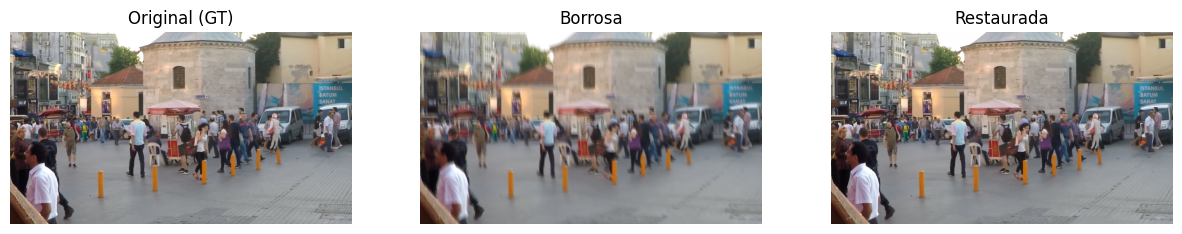

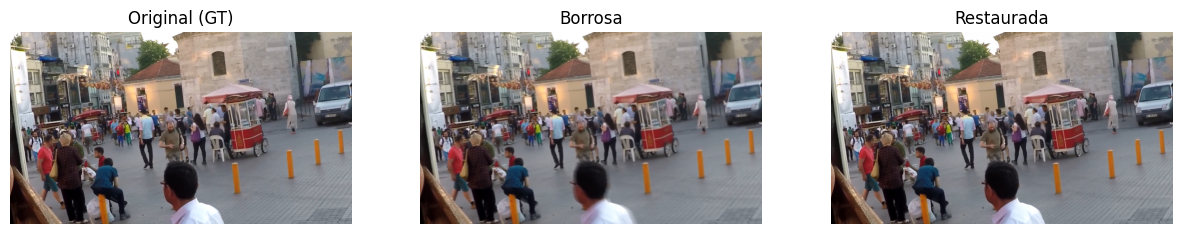

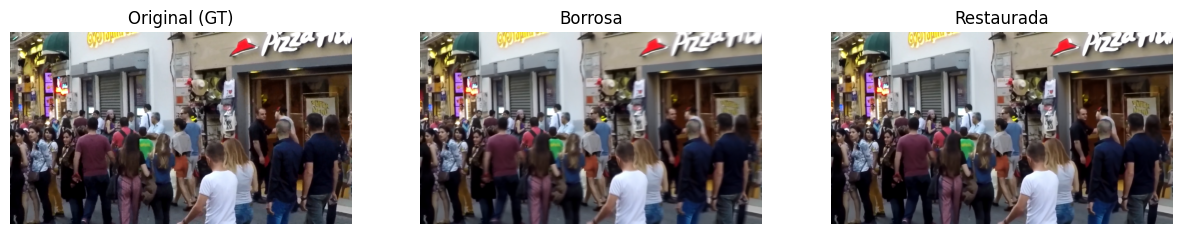

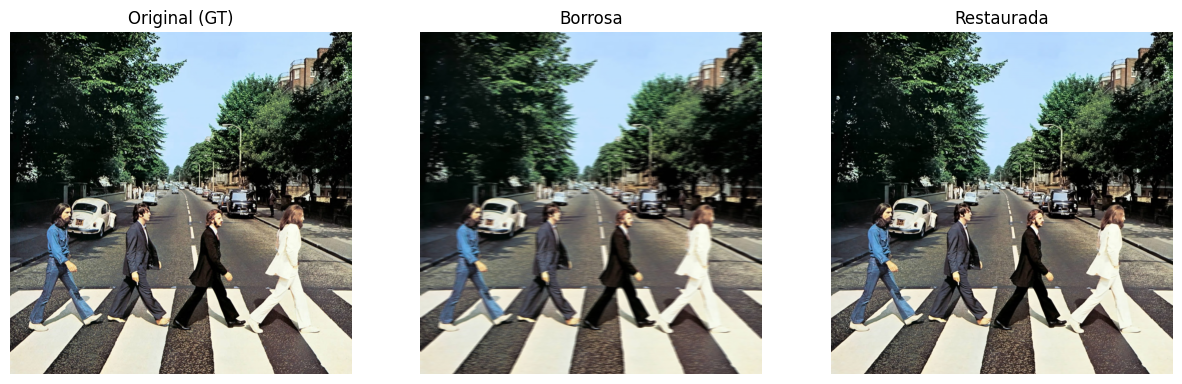

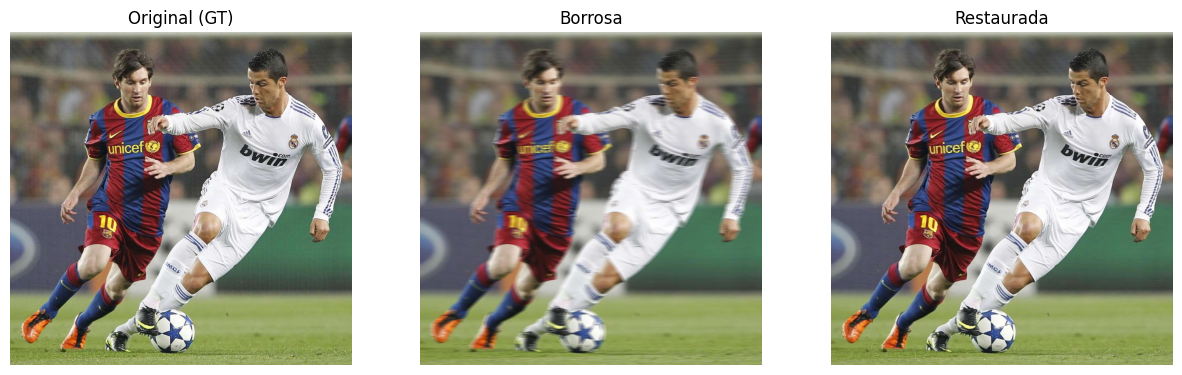

In [ ]:
#@title Ploteo
output_files = sorted([f for f in os.listdir(output_dir) if f.lower().endswith('.png')])

for fname in input_files:
  if fname in gt_files and fname in output_files:
    inp_img = np.array(Image.open(os.path.join(input_dir, fname)).convert('RGB'))
    gt_img = np.array(Image.open(os.path.join(gt_dir, fname)).convert('RGB'))
    res_img = np.array(Image.open(os.path.join(output_dir, fname)).convert('RGB'))

    plt.figure(figsize=(15, 5))
    plt.subplot(131), plt.imshow(inp_img), plt.title('Borrosa'), plt.axis('off')
    plt.subplot(132), plt.imshow(gt_img), plt.title('Original (GT)'), plt.axis('off')
    plt.subplot(133), plt.imshow(res_img), plt.title('Restaurada'), plt.axis('off')
    plt.show()


In [ ]:
#@title Metricas individuales

psnr_list, ssim_list, rmse_list = [], [], []

for fname in output_files:
  if gt_dir and fname in gt_files:
    gt_img_np = np.array(Image.open(os.path.join(gt_dir, fname)).convert('RGB')).astype(np.float32) / 255.0
    res_img_np = np.array(Image.open(os.path.join(output_dir, fname)).convert('RGB')).astype(np.float32) / 255.0

    psnr = psnr_loss(res_img_np, gt_img_np, data_range=1)
    ssim = ssim_loss(res_img_np, gt_img_np, data_range=1, channel_axis=2)
    rmse = np.sqrt(mse_loss(gt_img_np * 255.0, res_img_np * 255.0))
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    rmse_list.append(rmse)
    print(f"{fname}: PSNR={psnr:.2f}, SSIM={ssim:.4f}, RMSE: {rmse:.4f}")

if gt_dir:
  print(f"\nPSNR promedio: {np.mean(psnr_list):.4f}")
  print(f"SSIM promedio: {np.mean(ssim_list):.4f}")
  print(f"RMSE promedio: {np.mean(rmse_list):.4f}")

GOPR0384_11_00-000003.png: PSNR=34.26, SSIM=0.9443, RMSE: 4.9356
GOPR0384_11_00-000086.png: PSNR=27.87, SSIM=0.9096, RMSE: 10.3002
GOPR0384_11_05-004050.png: PSNR=34.97, SSIM=0.9607, RMSE: 4.5506
beatles.png: PSNR=30.04, SSIM=0.9275, RMSE: 8.0298
futbol.png: PSNR=29.64, SSIM=0.9091, RMSE: 8.4064

PSNR promedio: 31.3565
SSIM promedio: 0.9302
RMSE promedio: 7.2445
